# Homework 6

## ASTR 5900, Fall 2017, University of Oklahoma

### MCMC

# Problem 1

We are going to use the `emcee` package to estimate the parameters of our emission data given a double Gaussian plus background model as in HW4 Problem 1.B.  `emcee` uses affine invariant MCMC walkers to approximate distributions (http://dfm.io/emcee/current/).  Doing this problem requires a working knowledge of `emcee`.

### Part A

Load the data from `emission-line.dat`.

Before we can sample our distribution using MCMC, we must define it.  This week we will be defining our loglikelihood as a $\chi^2$: $$  \ln p(data | \vec{\theta})  = -\frac{1}{2}\sum_i \left(  \frac{y_{\text{model}}(x_i) - y_i}{\sigma_i}\right)^2  $$
As in HW4, we may assume that the error of each data point is the same (0.05).  In this case, the actual numerical value doesn't actually matter. (Do you know why?)

Define python functions for the log-prior, log-likelihood, and log-posterior.  If you use uniform priors for the parameters, you must have the log-prior function return a highly negative value if a paramter is out of your defined range.  I suggest returning `-np.inf`; read http://dfm.io/emcee/current/user/faq/#parameter-limits.

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from astropy.io import ascii
import astropy.table as Table
from scipy.optimize import curve_fit
import time
import multiprocessing as mp

#The amount of processors in the computer.
N_processors = mp.cpu_count()
#We want to use a maximum of 7 processors.
if N_processors > 7:
    N_processors = 7


In [2]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:
def chi2(science,model,std_science):
    if type(std_science) is not list:
        std_science = [std_science for x in science]
    return -0.5*(np.sum(((science-model)/std_science)**2))

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2./sigma**2)

def bimodalconstant(x,mu1,sigma1,A1,mu2,sigma2,A2,A3):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2) + A3

def log_prio(prior):
    # some default params, hardcoded
    amin = 0.
    amax = 50.
    sigmin = 0.
    sigmax = 50.
    mumin = -10.
    mumax = 10.
    if mumin <= prior[0] <= mumax:
        lnprobconst=0.0
    else:
        lnprobconst=-np.inf
    if amin <= prior[2] <= amax:
        lnprobconst=0.0
    else:
        lnprobconst=-np.inf
    if sigmin <= prior[1] <= sigmax:
        lnprobconst=0.0
    else:
        lnprobconst=-np.inf
    lnprior=lnprobconst
    return lnprior
    
def log_like(likelihood):
    return np.log(likelihood)
    
def log_post(Param,x,y,yerr):
    lp = log_prio(Param)
    if not np.isfinite(lp):
        return -np.inf
    return lp + chi2(y,bimodalconstant(x,*Param),yerr)


In [4]:
edata = ascii.read("emission-line.dat")
yerr = 0.05
col1="Frequency"
col2="Intensity"

### Part B

# Load the `emcee` package.

Remember the goal for this problem: to sample our log-posterior for all 7 parameters because doing so exactly is too computationally expensive.  We will use an `emcee.EnsembleSampler` object to sample our space.  `EnsembleSampler` objects need certain information at instantiation: number of dimensions our walkers will travel through, number of walkers, and the function they are sampling (our log-posterior).  The samplers also take certain keyword arguments, such as a list of additional arguments passed to the log-posterior function.
Consider reading the docs (https://media.readthedocs.org/pdf/emcee/stable/emcee.pdf#page=29).  The website linked above also contains information.

For this part, define the number of dimensions and number of walkers.  Instantiate an `EnsembleSampler` object (by assigning it to a variable).  Run the sampler by calling its `run_mcmc` method which needs two arguments: the initial positions of the walkers and the number of steps.  Make sure the initial positions of the walkers are within the allowed bounds as defined by the prior.

In [5]:
print(bcolors.FAIL + ' NANI KORE!!!! EMCEE ISN\'T A PART OF ANACONDA ALEX #FakeNews'+bcolors.ENDC)

 NANI KORE!!!! EMCEE ISN'T A PART OF ANACONDA ALEX #FakeNews


In [6]:
expected=[1. for x in range(7)]
params,cov=curve_fit(bimodalconstant,edata[col1],edata[col2],expected)
for i,j in enumerate(params):
    if i % 3 == 1:
        if j < 0:
            params[i] = np.abs(j)
xrange = int(max(edata[col1]) - min(edata[col1]))
x = np.linspace(int(min(edata[col1]))-xrange,int(max(edata[col1]))+xrange,len(edata[col1])*100 )

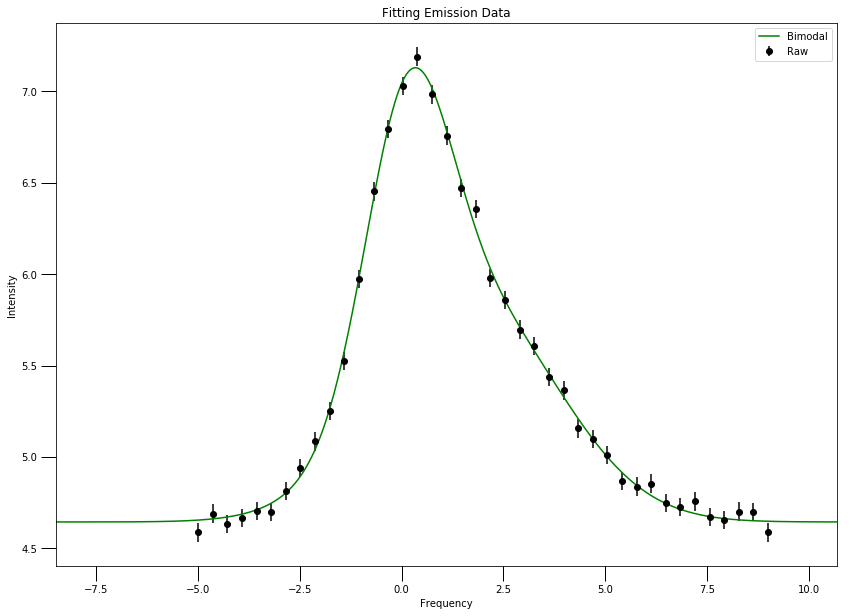

bimodalconstant(x,mu1,sigma1,A1,mu2,sigma2,A2,A3) = bimodalconstant(x,1.68,2.16,1.2,0.132,1.03,1.52,4.64) 
log prior: 0.0


In [7]:
plt.clf()
plt.figure(figsize=(14,10))

plt.title("Fitting Emission Data")
plt.xlabel("Frequency")
plt.ylabel("Intensity")
plt.tick_params('both', which='major', length=15, width=1)
plt.tick_params('both', which='minor', length=7.5, width=1)

plt.errorbar(edata[col1], edata[col2], yerr=0.05, fmt='o',label="Raw",color="black")
line3 = plt.plot(x,bimodalconstant(x,*params),color='green',label='Bimodal')

plt.xlim(min(edata[col1])-xrange/4.,max(edata[col2])+xrange/4.)
plt.legend()
plt.show()

print("bimodalconstant(x,mu1,sigma1,A1,mu2,sigma2,A2,A3) = "+bcolors.OKGREEN+\
      "bimodalconstant(x,{0:.3},{1:.3},{2:.3},{3:.3},{4:.3},{5:.3},{6:.3}) ".format(*params)+bcolors.ENDC)
print("log prior: {}".format(log_prio(params)))

In [21]:
nwalkers = 200
ini_params = [x + 0.01*np.random.randn(nwalkers) for x in params]
print("Params: {}".format(params))
print("Range of initial params:")
for i in ini_params:
    print(min(i),max(i))
posNew=(np.array(ini_params)).T
print("New Params: {}".format(posNew[0]))
print("Shape: {}".format(posNew.shape))
initial_log_prio=np.zeros(nwalkers)
for i in np.arange(nwalkers):
    paramtemp=posNew[i,:]
    initial_log_prio[i]=log_prio(paramtemp)

print("initial_log_prio.min: {}".format(initial_log_prio.min()))
print("initial_log_prio.max: {}".format(initial_log_prio.max()))

Params: [ 1.67503711  2.16308949  1.20238042  0.13166179  1.03445726  1.52123771
  4.64429413]
Range of initial params:
(1.6451759261787973, 1.7063913133261708)
(2.1368717247491267, 2.1886997020859473)
(1.1739090023224101, 1.2261412503128093)
(0.10216676556920233, 0.16032239286049593)
(1.0119070368359757, 1.063919158788456)
(1.4936550037060283, 1.5542369353750545)
(4.6168053662095501, 4.6664098271675671)
New Params: [ 1.69134532  2.16223234  1.19982526  0.13442935  1.04393049  1.5181002
  4.63084205]
Shape: (200, 7)
initial_log_prio.min: 0.0
initial_log_prio.max: 0.0


In [9]:
ndim=params.shape[0]
print("Number of dimensions: {}".format(ndim))
numsims=10000
print("Number of sims: {}".format(numsims))
time1 = time.time()
print("Time Starting: "+ str(time1))
print("Starting emcee on {} processors...".format(N_processors))
samplerNew = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(edata[col1],edata[col2],yerr),threads = N_processors)
samplerNew.run_mcmc(posNew, numsims)
print("Finished")
time2 = time.time()
print("Time Finished: "+ str(time2))
print("Time from start: {}s".format(int(time2-time1)))
chain=samplerNew.chain
lnprob=samplerNew.lnprobability
acceptance=samplerNew.acceptance_fraction

Number of dimensions: 7
Number of sims: 10000
Starting emcee on 7 processors...
Finished
Time from start: 1207s


### Part C

Plot the acceptance fraction of each walker.  Also plot the evolution of the walkers, which is accessed va `EnsembleSampler.chain`.  You may notice the distribution of walkers is very thin at the beginning of the evolution; we only want to consider a 'burnt-in' chain otherwise our results will be biased towards the initial positions of the walkers.  Remove the part of the chain before where the walkers are burnt-in.

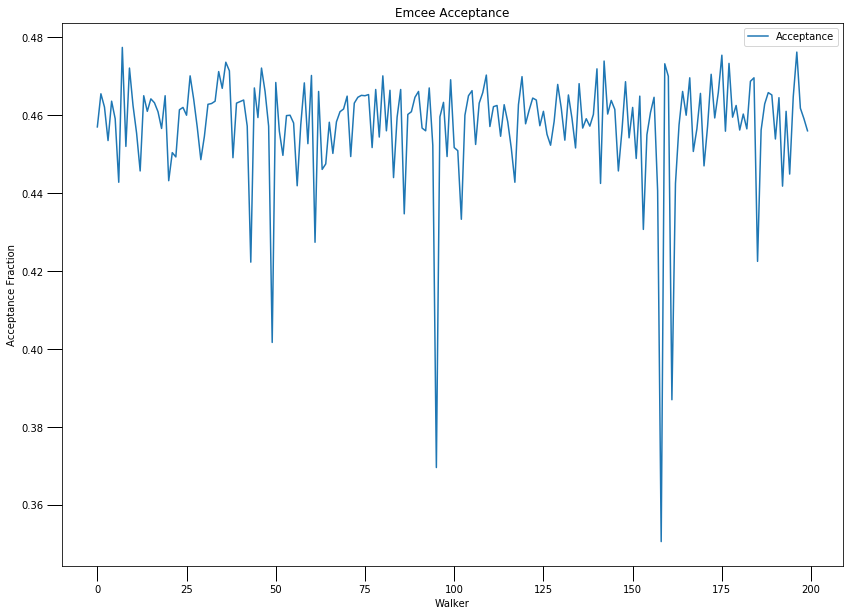

In [17]:
plt.clf()
plt.figure(figsize=(14,10))

plt.title("Emcee Acceptance")
plt.tick_params('both', which='major', length=15, width=1)
plt.tick_params('both', which='minor', length=7.5, width=1)

plt.xlabel('Walker')
plt.ylabel('Acceptance Fraction')
plt.plot(acceptance,label="Acceptance")
plt.legend()
plt.show()

### Part D 

Using `EnsembleSampler.chain`, find a point estimate  and 95% credible region for each of the parameters.

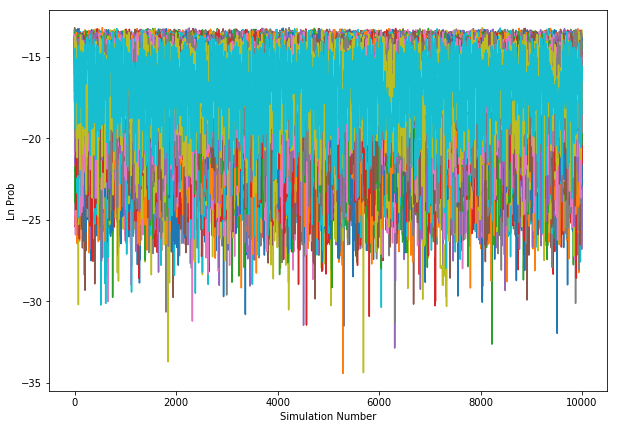

In [18]:
index=np.arange(numsims)

plt.clf()
plt.figure(figsize=[10,7])
plt.xlabel('Simulation Number')
plt.ylabel('Ln Prob')

for i in range(nwalkers):
    plt.plot(index,lnprob[i,0:numsims],label="Walkers: {}".format(i))
plt.show()

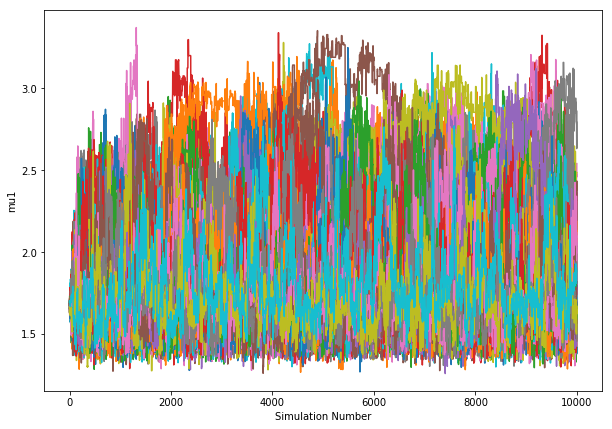

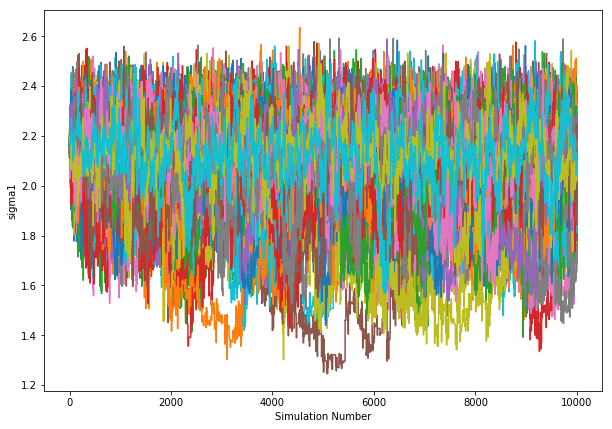

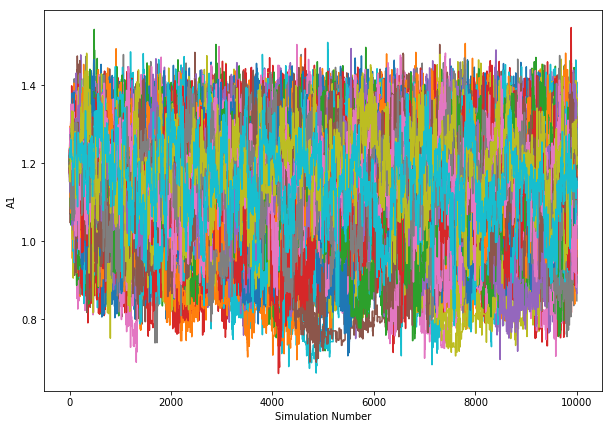

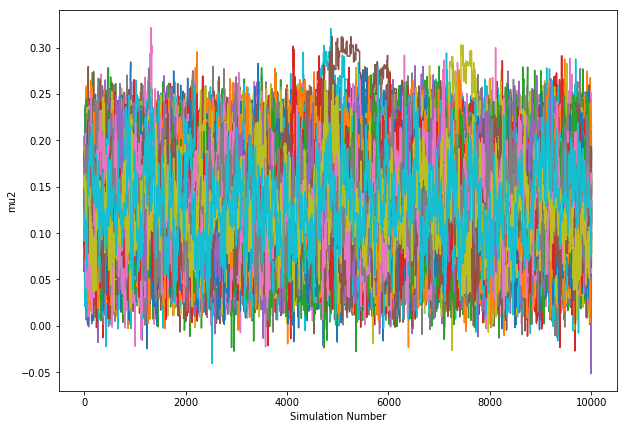

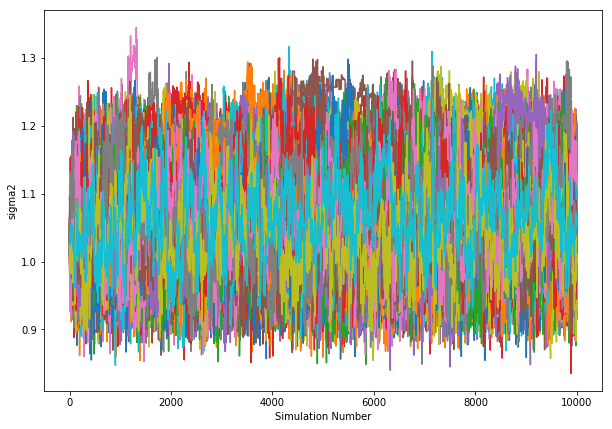

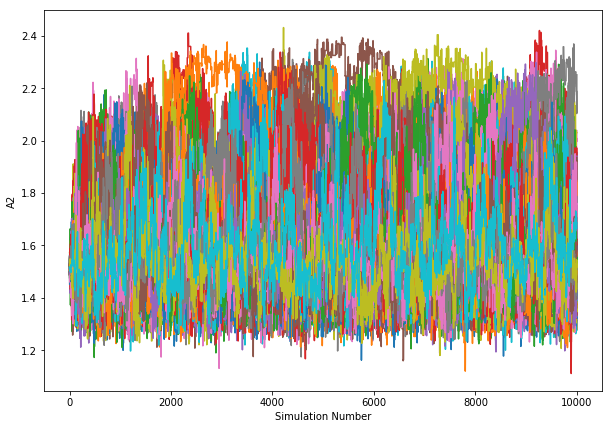

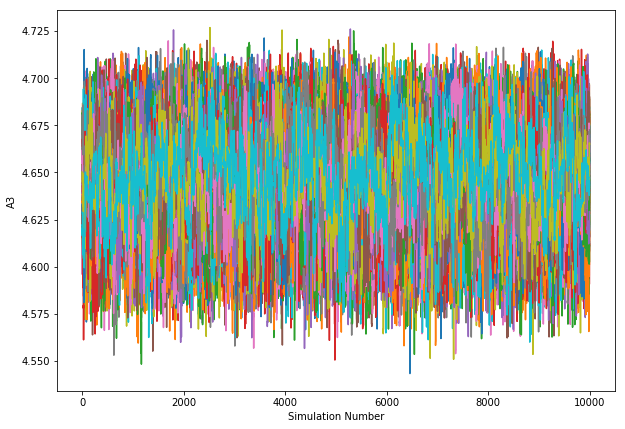

In [19]:
#bimodalconstant(x,mu1,sigma1,A1,mu2,sigma2,A2,A3)
labeling = ["mu1","sigma1","A1","mu2","sigma2","A2","A3"]
for a,j in enumerate(range(chain.shape[2])):
    plt.clf()
    plt.figure(figsize=[10,7])
    plt.xlabel('Simulation Number')
    plt.ylabel(labeling[a])

    for i in range(nwalkers):
        plt.plot(index,chain[i,0:numsims,j])
    plt.show()

In [39]:
print("Shape chains: {}".format(chain.shape))
print("Point source estimations vs fit params")
point_source_params = []
for i in range(chain.shape[2]):
    point_source_params.append(np.average(chain[:,:,i]))
    print("{}: {} vs {}".format(labeling[i],point_source_params[i],params[i])) 

Shape chains: (200, 10000, 7)
Point source estimations vs fit params
mu1: 1.7753195591 vs 1.67503711464
sigma1: 2.12687034176 vs 2.1630894907
A1: 1.16370626245 vs 1.20238041567
mu2: 0.133149894051 vs 0.131661786
sigma2: 1.05650259893 vs 1.03445726142
A2: 1.58269533534 vs 1.52123770555
A3: 4.64661977304 vs 4.64429413106


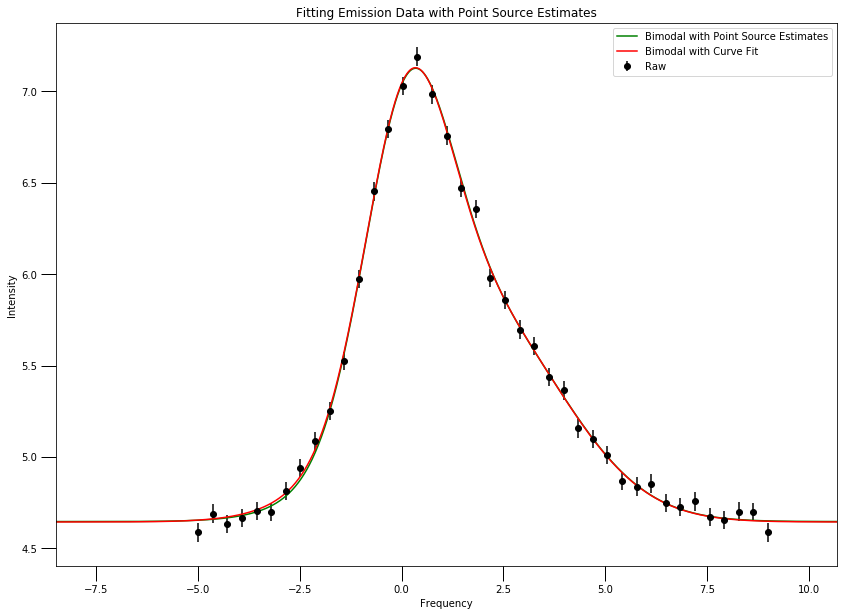

In [37]:
plt.clf()
plt.figure(figsize=(14,10))
x = np.linspace(int(min(edata[col1]))-xrange,int(max(edata[col1]))+xrange,len(edata[col1])*100 )
plt.title("Fitting Emission Data with Point Source Estimates")
plt.xlabel("Frequency")
plt.ylabel("Intensity")
plt.tick_params('both', which='major', length=15, width=1)
plt.tick_params('both', which='minor', length=7.5, width=1)

plt.errorbar(edata[col1], edata[col2], yerr=0.05, fmt='o',label="Raw",color="black")
line3 = plt.plot(x,bimodalconstant(x,*point_source_params),color='green',label='Bimodal with Point Source Estimates')
line4 = plt.plot(x,bimodalconstant(x,*params),color='red',label='Bimodal with Curve Fit')

plt.xlim(min(edata[col1])-xrange/4.,max(edata[col2])+xrange/4.)
plt.legend()
plt.show()

In [81]:
def MakeHistogram(samples, index, numbins=100):
    numout=len(samples)
    comp=samples[0:numout,index]
    comp_histogram=np.array(np.histogram(comp,bins=numbins,range=[comp.min(),comp.max()],density=1))
    comp_histogram_y=comp_histogram[0]
    temp=comp_histogram[1]
    binsize=temp[1]-temp[0]
    comp_histogram_x=comp.min()+0.5*binsize+binsize*np.arange(numbins)
    return comp_histogram_x,comp_histogram_y

print chain.shape
burnin=0
ndim=chain.shape[2]

lnprob2=lnprob[:,burnin:].reshape((-1))
temp=chain[:,burnin:,0:ndim]
sample=temp.reshape(((numsims-burnin)*nwalkers,ndim))

print lnprob2.shape
print sample.shape

(200, 10000, 7)
(2000000,)
(2000000, 7)


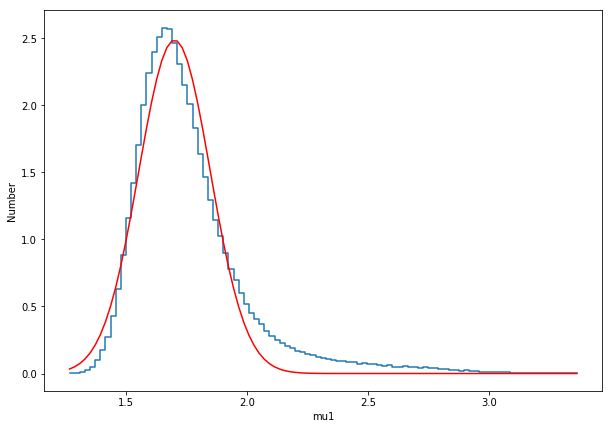

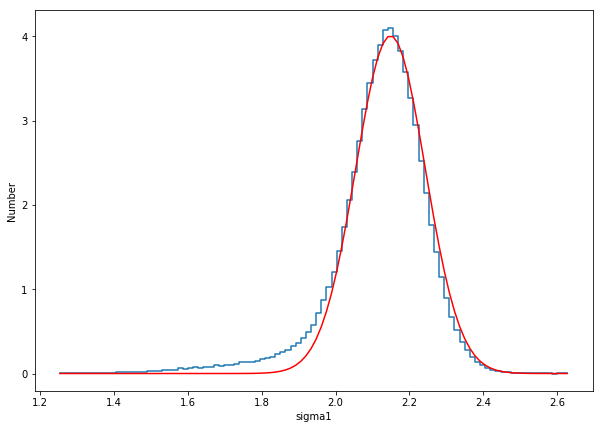

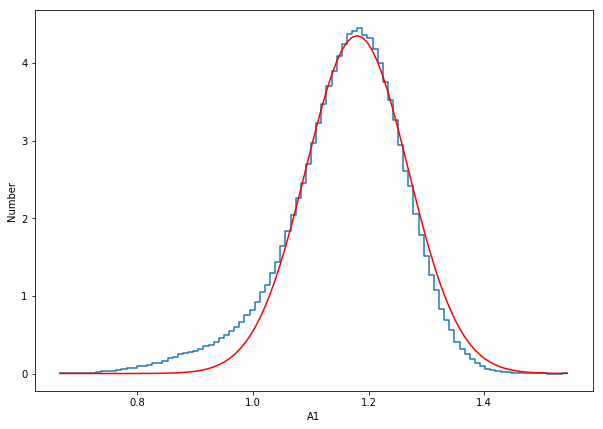

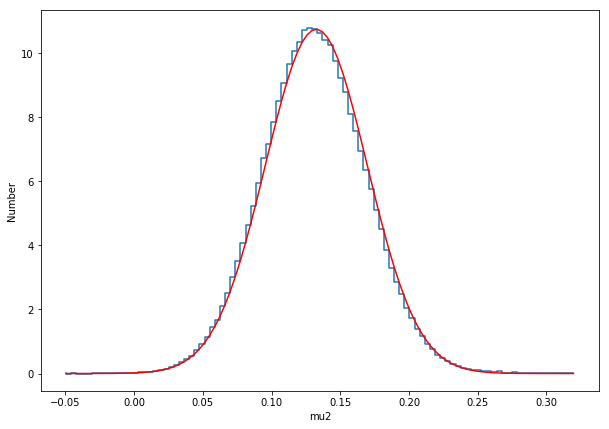

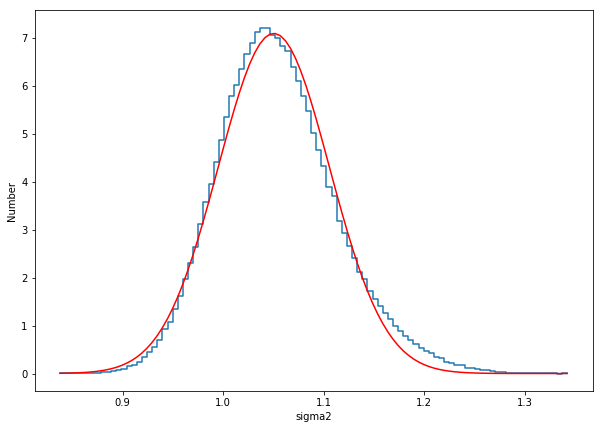

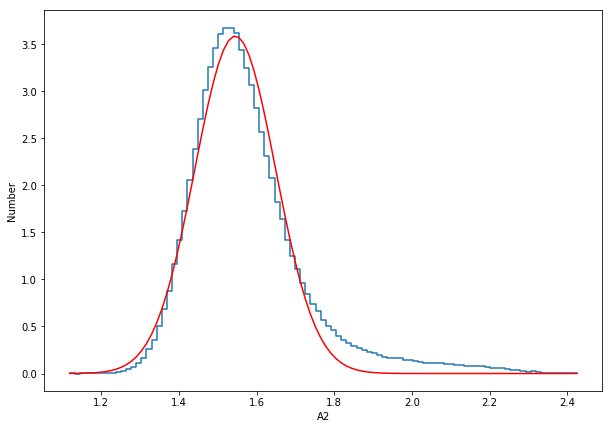

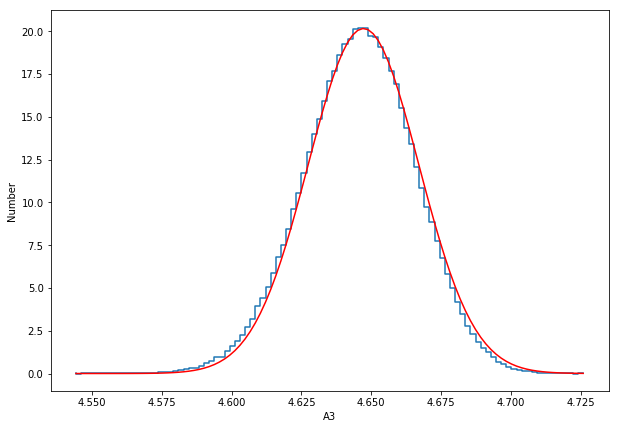

In [100]:
sigma=[]
for index in range(ndim):
    plt.clf()
    plt.figure(figsize=[10,7])
    comp_hist_0_x,comp_hist_0_y=MakeHistogram(sample,index,)
    plt.xlabel(labeling[index])
    plt.ylabel('Number')
    plt.plot(comp_hist_0_x,comp_hist_0_y,drawstyle='steps')
    expected = [1. for x in range(3)]
    params,cov = curve_fit(gauss,comp_hist_0_x,comp_hist_0_y,expected)
    #sigma.append(np.sqrt(np.diag(cov)))
    sigma.append(params[1])
    line4 = plt.plot(comp_hist_0_x,gauss(comp_hist_0_x,*params),color='red')
    plt.show()

In [101]:
print("The 95%(3sigma) confidence regions for the parameters are as follows:")
for i in range(ndim):
    print("{}: {} +- {}".format(labeling[i],point_source_params[i],sigma[i]*3))

The 95%(3sigma) confidence regions for the parameters are as follows:
mu1: 1.7753195591 +- 0.442568547349
sigma1: 2.12687034176 +- -0.282802478326
A1: 1.16370626245 +- -0.265394672237
mu2: 0.133149894051 +- -0.111001903461
sigma2: 1.05650259893 +- -0.166011701267
A2: 1.58269533534 +- 0.311651774813
A3: 4.64661977304 +- 0.0593017695716


On dimension: 0


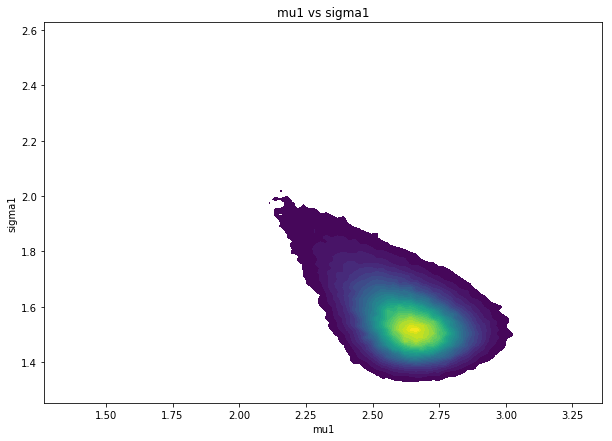

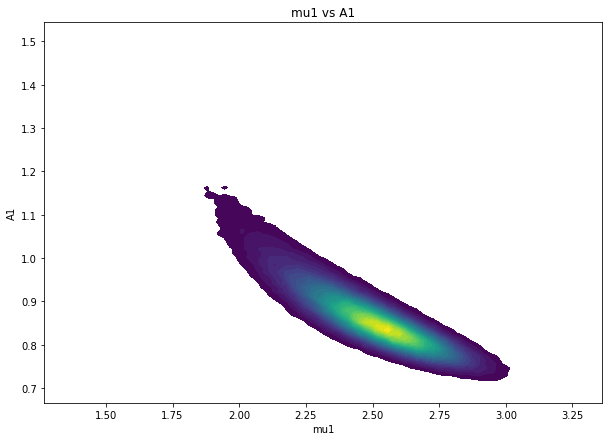

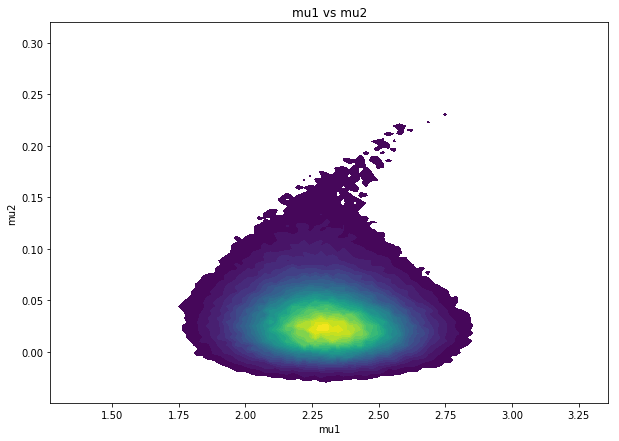

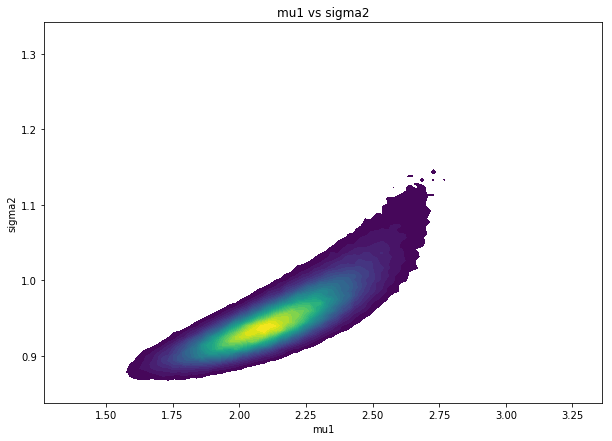

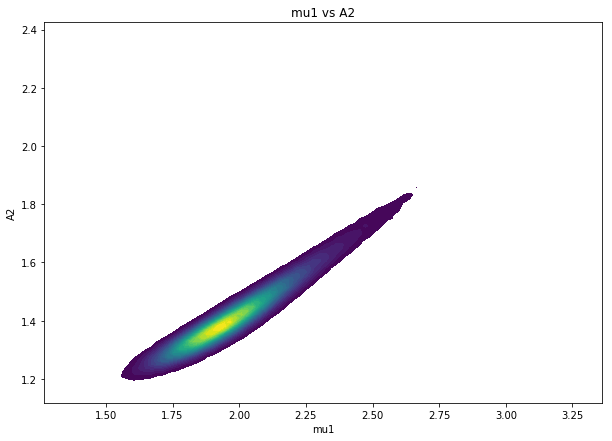

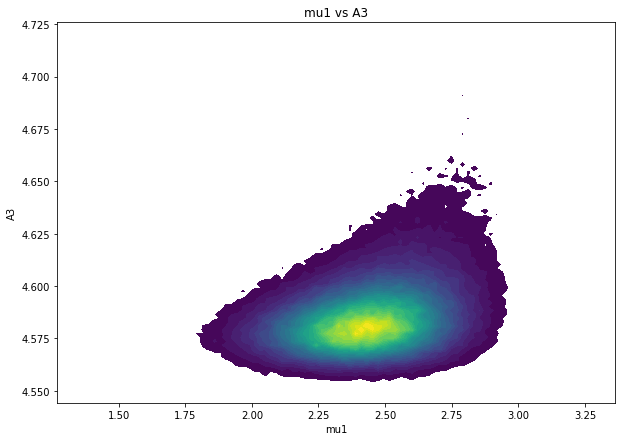

On dimension: 1


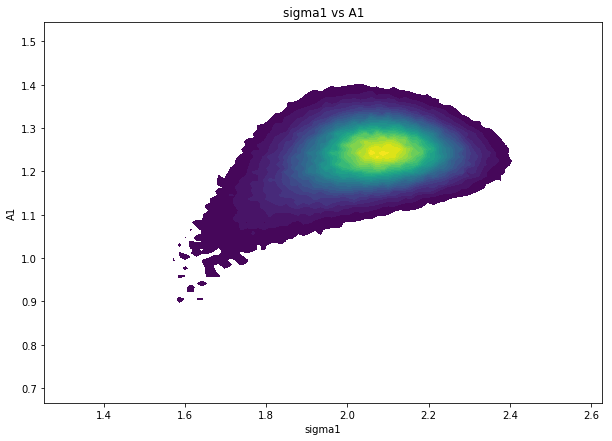

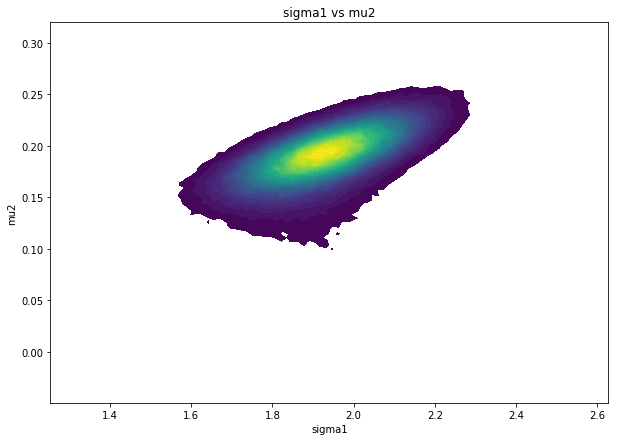

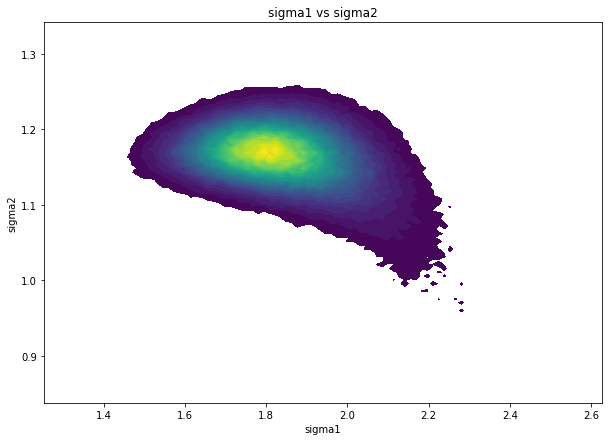

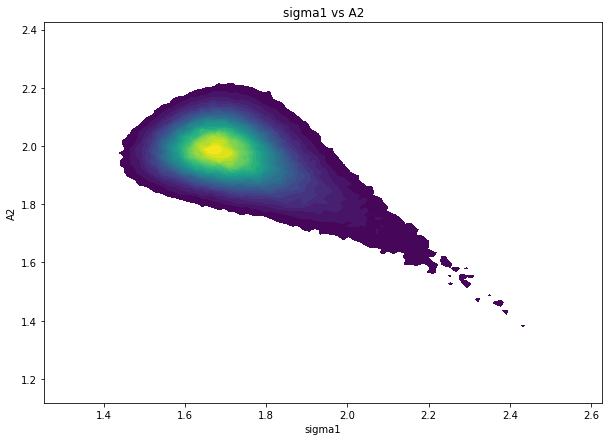

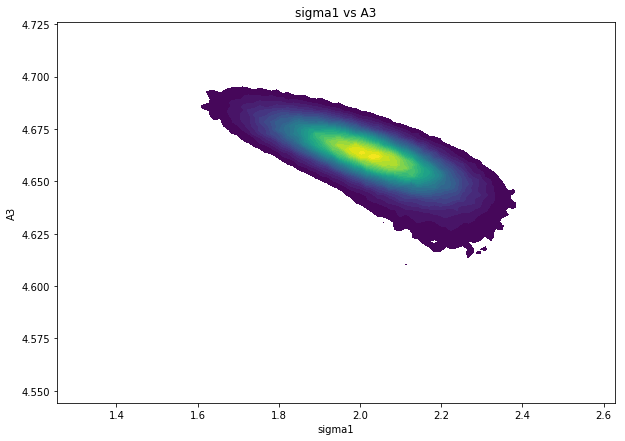

On dimension: 2


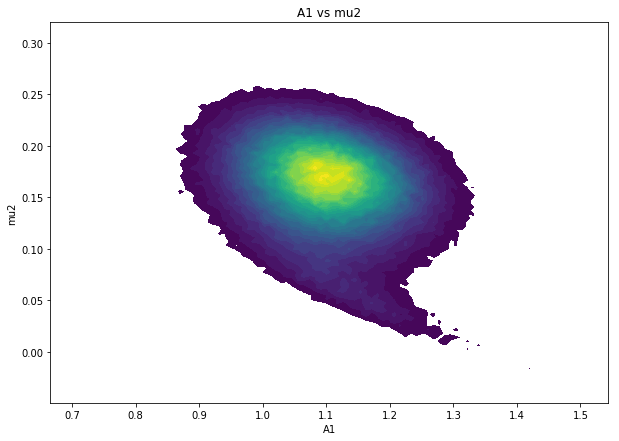

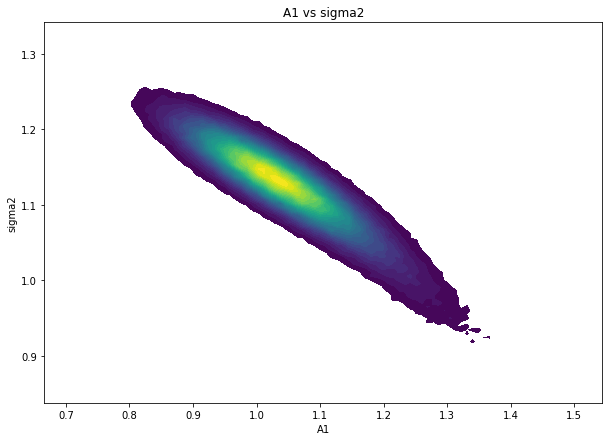

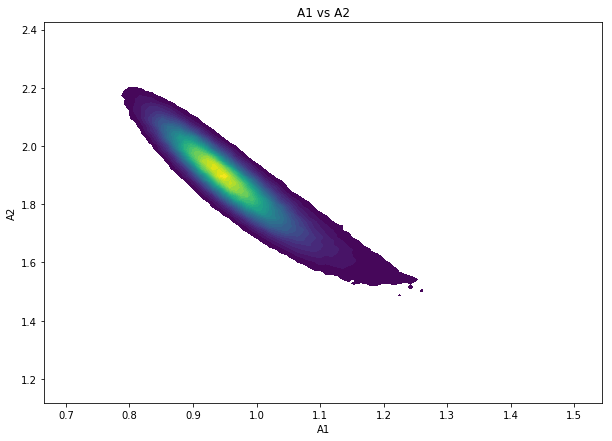

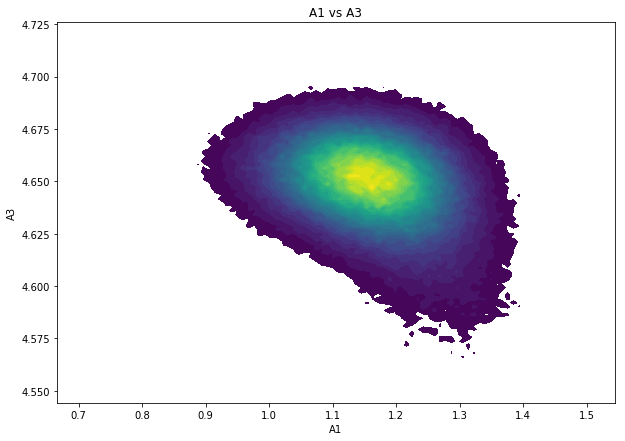

On dimension: 3


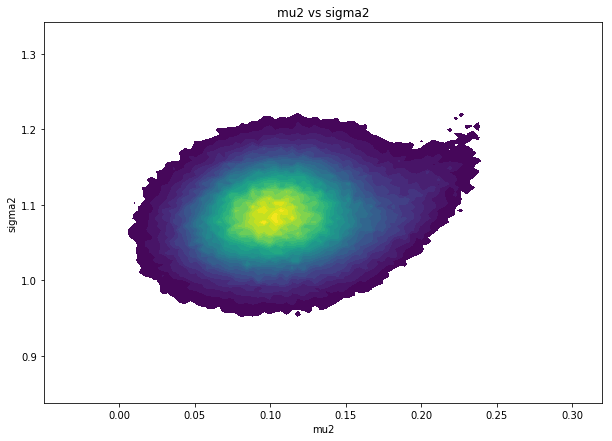

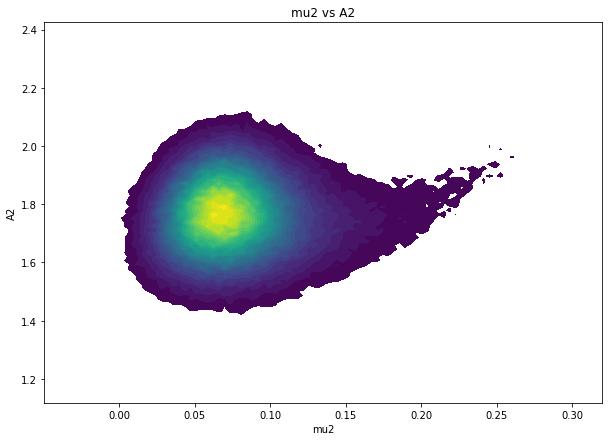

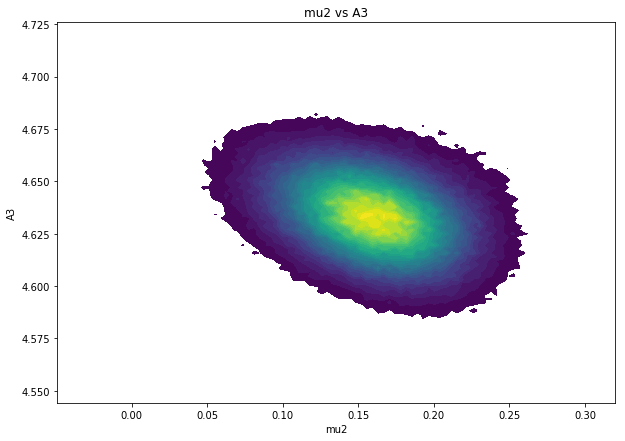

On dimension: 4


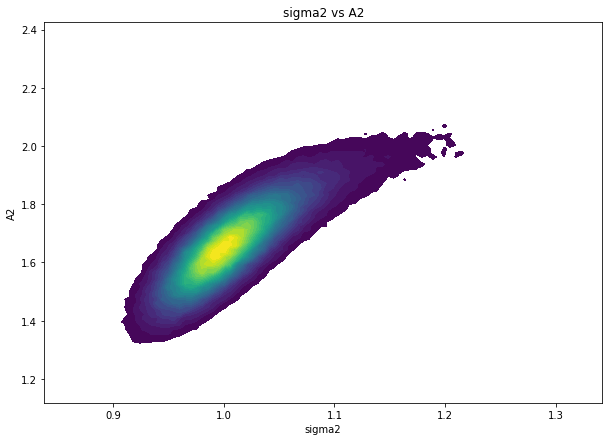

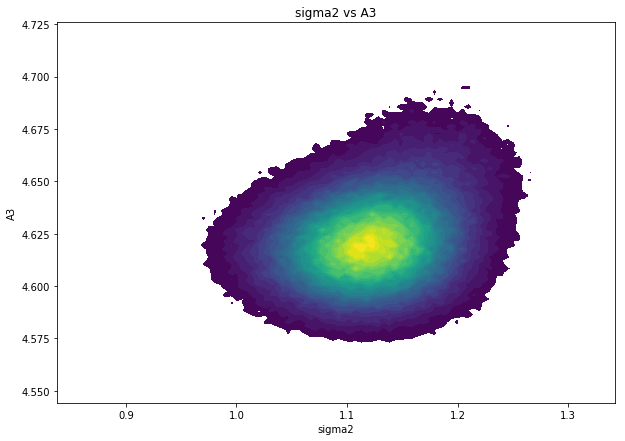

On dimension: 5


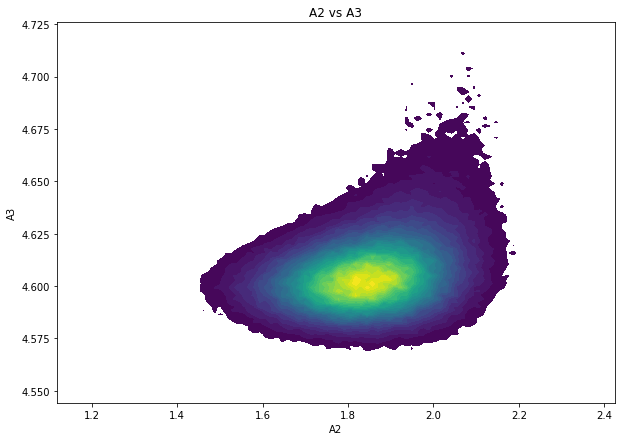

On dimension: 6


In [92]:
percent_regions=[1.0-0.9973,1.0-0.9545,1.0-0.6827,0.5,0.6827,0.9545,0.9973]

confidence_regions_params=np.zeros([7,ndim])

numsamples=len(sample)
numbins = 100
for i in np.arange(ndim):
    temp=sample[:,i]
    x2=np.sort(temp)
    f2=np.array(range(numsamples))/float(numsamples)
    confidence_regions_params[0:7,i]=np.interp(percent_regions,f2,x2)

def PlotDensity(density, pos1out, pos2out):
    delta=density.max()/30.0
    levels=delta+delta*np.arange(30)
    plt.contourf(pos1out,pos2out,density,levels)

def MakeContour(samples, index1, index2, numbins):
     numout=len(samples)
     comp1=samples[0:numout,index1]
     comp2=samples[0:numout,index2]
     binsize1=(comp1.max()-comp1.min())/numbins
     binsize2=(comp2.max()-comp2.min())/numbins
     density=np.zeros([numbins,numbins])
     pos1=(comp1-comp1.min())/binsize1
     pos2=(comp2-comp2.min())/binsize2
     pos1out=comp1.min()+0.5*binsize1+binsize1*np.arange(numbins)
     pos2out=comp2.min()+0.5*binsize2+binsize2*np.arange(numbins)
     for i in range(numout):
        if (long(pos1[i])) < numbins and (long(pos2[i])) < numbins:
            density[long(pos1[i]),long(pos2[i])]=density[long(pos1[i]),long(pos2[i])]+1.0
     return density, pos1out, pos2out


for i in range(ndim):
    print("On dimension: {}".format(i))
    for j in range(ndim):
        if i < j:
            plt.clf()
            plt.figure(figsize=[10,7])
            plt.xlabel(labeling[i])
            plt.ylabel(labeling[j])
            plt.title(labeling[i]+" vs "+labeling[j])
            density, pos1out, pos2out=MakeContour(sample,i,j,numbins)
            PlotDensity(density,pos1out,pos2out)
            plt.show()

### Part E

Which 2 parameters do you think would have the highest covariance?  Least?  Why?  Discuss, then plot the joint-distributions of both pairs of parameters.

### If I just had to guess I would assume either the mu1 and mu2 parameters would have the highest covariance since the gaussians can be fairly unresolved, however mu1 and a2 or coversely mu2 and a1 would have higher. In either case both of these should have the highest covariance.

### The ones with the least would be a3 and sig1 or sig2. This is because the level of the background has little to no bearing on the spread of the data

Was your answer affirmed?  If you got results you didn't expect, discuss why might the parameters be correlated/uncorrelated.

### My answer was more or less confirmed

# Problem 2

Consider a 2D lattice of size $L \times L$.  In this model, we want to randomly assign a value of 0 or 1 to each of the lattice sites in such a way that no two adjacent vertices both take the value of 1 (two lattice sites are adjacent if they share an edge).  A configuration that meets this condition is known as *feasible*.  For now we will pick random configurations such that each feasible configuration has an equal probability, while infeasible configurations have a probability of precisely 0.  One might ask,what is the expected number of 1's in our grid?  That is: 

$$ E \left[ n(X)\right]  = \sum_{\xi} n(\xi) P(\xi)$$
where $\xi$ is a possible configuration.

Write your own MCMC algorithm from scratch to evaluate this expectation value for a grid of length 8.  You are limited to default python and the `numpy` package.

In order to use an MCMC algorithm for this model, you must use a Markov chain whose state space is the set of all feasible configurations.  In order to have a stationary distribution, the Markov chain must be aperiodic and irreducible.  Such a Markov chain can be constructed by the following process.

1. Start in a feasible configuration.

2. For each integer time $t+1$:

    1. Pick a vertex at random, uniformly 
    2. Toss a fair coin 
    3. If the coin is heads and all neighbors of the vertex is 0, set the vertex to 0. Set the vertex to 0 otherwise.
    



In [14]:
def latticecreate(sl=8,times=1,Verbosity=True):
    if Verbosity:
        print("Creating Lattice...")
    lattice2d = np.zeros((sl,sl),dtype=int)
    x = 0
    ones = 0
    values = []
    while x < times:        
        # any vertex 
        temp = np.random.randint(0,2) 
        i = np.random.randint(0,sl)
        a = np.random.randint(0,sl)
          
        '''        
        breaker = True
        while breaker == True: # unique vertices only or nonunique with 0
            temp = np.random.randint(0,2) 
            i = np.random.randint(0,sl)
            a = np.random.randint(0,sl)
            if ([i,a] not in values) or (lattice2d[i][a] == 0):
                values.append([i,a])
                breaker = False
        '''
        status = True
        if (temp == 1):
            if i<(sl-1):
                if lattice2d[i+1][a] == 1:
                    status = False
            if i>0:
                if lattice2d[i-1][a] == 1:
                    status = False
            if a<(sl-1):
                if lattice2d[i][a+1] == 1:
                    status = False
            if a>0:
                if lattice2d[i][a-1] == 1:
                    status = False
            if (status == True):
                lattice2d[i][a] = 1
                if Verbosity:
                    print("Coin Flip: {}".format(temp))
        else:
            lattice2d[i][a] = 0
            if Verbosity:
                print("Coin Flip: {}".format(temp))

        x += 1
        
    if Verbosity:
        print("Finished")
    for i in lattice2d:
        for j in i:
            if j == 1:
                ones += 1
    return ones,lattice2d

In [15]:
one_arrays=[]
iterations = 2000
size = 8
for i in range(1,iterations+1):
    numones, testing = latticecreate(size,i,False) # size of square lattice, flips, verbose output
    one_arrays.append(numones)
    #print testing
    #print("Num ones: {}".format(numones))

#print(one_arrays)

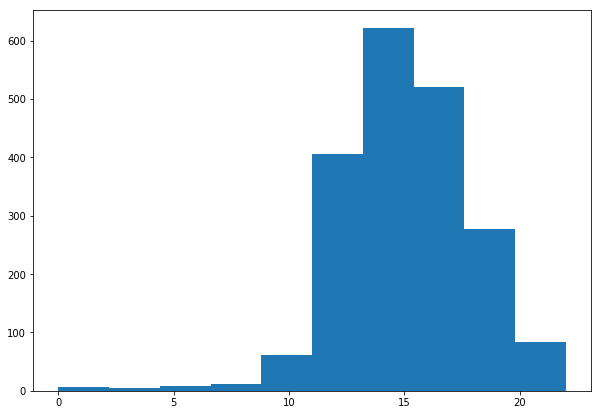

Expected number of ones: 15.0 for lattice(8,8)


In [16]:
plt.clf()
plt.figure(figsize=[10,7])
counts,bins,ignore = plt.hist(one_arrays)
mbins = 0.5*(bins[1:] + bins[:-1])
plt.show()
weighting = mbins*counts
print("Expected number of ones: {0:.3} for lattice({1},{1})".format(np.average(weighting)/np.average(counts),size))

### Discussion

Why must we use MCMC for this problem?  Be specific about why we can't sample the state space exactly.

### A MCMC allows us to randomize our steps within a statespace so that as we increase the number of samples, the more reliable or accurate our estimation becomes. This Markov Chain will contain the entire statespace of possible parameters and allows an easy minimization of the chi2 function to an absolute min of the give state space instead of finding local minima. 